In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from scipy.stats import randint, uniform, loguniform

In [3]:
data = pd.read_csv("final_preprocessed_data.csv")
print("Data shape:", data.shape)

Data shape: (884751, 43)


In [4]:
column_list = list(data.columns)

for column in column_list:
    print(column)

fox headline mentions (log)
nyt lead paragraph mentions (log)
nyt headline mentions (log)
percent total population two or more races white and american indian and alaska native
percent citizen, voting age population citizen, 18 and over population female
percent citizen, voting age population citizen, 18 and over population male
percent hispanic or latino and total population not hispanic or latino black or african american alone
estimate total population one race asian asian indian (log)
percent race alone or in combination with one or more other races total population black or african american
percent total population one race black or african american
percent total population one race asian asian indian
estimate hispanic or latino and total population not hispanic or latino black or african american alone (log)
estimate race alone or in combination with one or more other races total population black or african american (log)
estimate hispanic or latino and total population hispanic 

In [5]:
X = data.drop(columns=['won_county'])
y = data['won_county']

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)

Feature matrix X shape: (884751, 42)
Target vector y shape: (884751,)


##Logistic Regression

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

# Sample 5% of the dataset
X_sample = X.sample(frac=0.05, random_state=42)
y_sample = y.loc[X_sample.index]

#Standardize features
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Define Logistic Regression model
lr = LogisticRegression(
    max_iter=1000,
    solver='saga',
    random_state=42,
    n_jobs=-1
)

# Define hyperparameter search space
param_dist_lr = {
    'C': loguniform(1e-3, 1e2),
    'penalty': ['l1', 'l2']
}

# Setup RandomizedSearchCV
random_search_lr = RandomizedSearchCV(
    lr,
    param_distributions=param_dist_lr,
    n_iter=5,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Train the model
random_search_lr.fit(X_sample_scaled, y_sample)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=LogisticRegression(max_iter=1000, n_jobs=-1,
                                                random_state=42,
                                                solver='saga'),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ccdca072b10>,
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='f1')

In [12]:

# best hyperparameters
print("Best Logistic Regression Parameters (5% Sample):")
print(random_search_lr.best_params_)

# Cross-validation evaluation
cv_results_lr = cross_validate(
    random_search_lr.best_estimator_, X_sample_scaled, y_sample,
    cv=3,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)

# Output average cross-validation results
print("\n Quick Logistic Regression Cross-Validation Results (5% Sample):")
for metric in cv_results_lr:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_lr[metric]):.4f}")



Best Logistic Regression Parameters (5% Sample):
{'C': np.float64(0.9846738873614566), 'penalty': 'l1'}

 Quick Logistic Regression Cross-Validation Results (5% Sample):
test_accuracy: 0.7427
test_precision: 0.7355
test_recall: 0.7474
test_f1: 0.7414
test_roc_auc: 0.8109


### Final Model for Logistic Regression

In [7]:

# Define the final Logistic Regression model
best_lr = LogisticRegression(
    C=0.9847,
    penalty='l1',
    solver='saga',
    max_iter=1000,
    random_state=42,
    n_jobs=-1
)

# Cross-Validation
cv_results_best_lr = cross_validate(
    best_lr, X_scaled, y,
    cv=3,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False,
    n_jobs=-1
)


In [24]:
# Output average cross-validation results
print("\nLogistic Regression Result: ")
for metric in cv_results_best_lr:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_best_lr[metric]):.4f}")


Logistic Regression Result: 
test_accuracy: 0.5460
test_precision: 0.5635
test_recall: 0.4525
test_f1: 0.4900
test_roc_auc: 0.5730


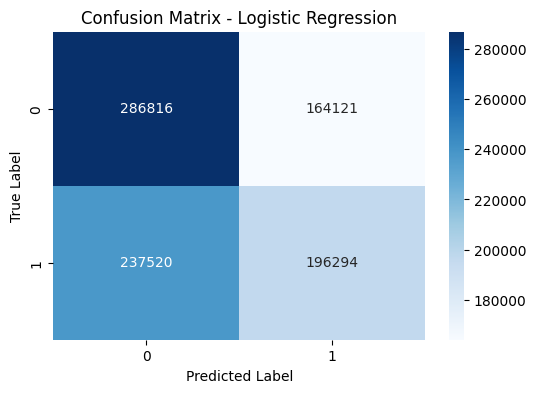


Classification Report - Logistic Regression:
              precision    recall  f1-score   support

           0       0.55      0.64      0.59    450937
           1       0.54      0.45      0.49    433814

    accuracy                           0.55    884751
   macro avg       0.55      0.54      0.54    884751
weighted avg       0.55      0.55      0.54    884751



In [13]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns

# Predict cross-validated results
y_pred_lr = cross_val_predict(best_lr, X_scaled, y, cv=3, n_jobs=-1)

# Confusion Matrix
conf_mat_lr = confusion_matrix(y, y_pred_lr)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report - Logistic Regression:")
print(classification_report(y, y_pred_lr))


## XGB

In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler

# Sample 5% of the dataset
X_sample = X.sample(frac=0.05, random_state=42)
y_sample = y.loc[X_sample.index]

# Standardize features
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Define the XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

# Define the hyperparameter
param_dist_xgb = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# Set up RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Train the model
random_search_xgb.fit(X_sample_scaled, y_sample)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:50:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ccda2e84710>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ccdcfbc8590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7ccda2e84c50>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ccdcfbcaf50>},
                   random_state=42, scoring='f1')

In [17]:
# Output best hyperparameters
print("\nBest XGBoost Parameters (5% Sample):")
print(random_search_xgb.best_params_)

# Cross-validation
cv_results_xgb_sample = cross_validate(
    random_search_xgb.best_estimator_, X_sample_scaled, y_sample,
    cv=3,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    return_train_score=False
)

# Output average cross-validation results
print("\nQuick XGBoost Cross-Validation Results (5% Sample):")
for metric in cv_results_xgb_sample:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_xgb_sample[metric]):.4f}")


Best XGBoost Parameters (5% Sample):
{'colsample_bytree': np.float64(0.935552788417904), 'learning_rate': np.float64(0.06990213464750791), 'max_depth': 9, 'n_estimators': 163, 'subsample': np.float64(0.8400288679743939)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Quick XGBoost Cross-Validation Results (5% Sample):
test_accuracy: 0.9133
test_precision: 0.9141
test_recall: 0.9101
test_f1: 0.9120
test_roc_auc: 0.9773


### Final Model for XGB

In [18]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the final XGBoost model with best params
xgb_final = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    n_estimators=163,
    max_depth=9,
    learning_rate=0.0699,
    subsample=0.8400,
    colsample_bytree=0.3555
)

# Cross-Validation
cv_results_xgb_final = cross_validate(
    xgb_final, X_scaled, y,
    cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_train_score=False,
    n_jobs=-1
)



=== XGBoost Full Data 5-Fold CV Results ===
test_accuracy: 0.6871
test_precision: 0.7048
test_recall: 0.6746
test_f1: 0.6667


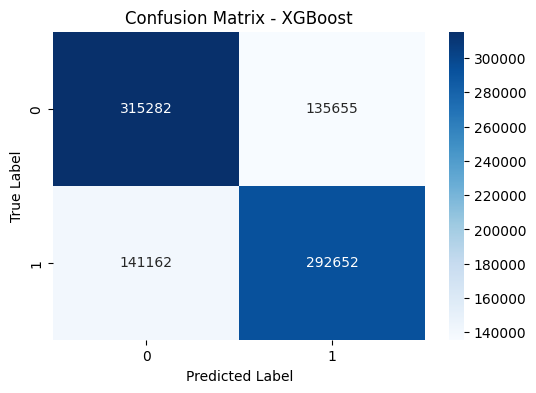


Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69    450937
           1       0.68      0.67      0.68    433814

    accuracy                           0.69    884751
   macro avg       0.69      0.69      0.69    884751
weighted avg       0.69      0.69      0.69    884751



In [20]:
# Output average cross-validation results
print("\nXGBoost Full Data 5-Fold CV Results")
for metric in cv_results_xgb_final:
    if 'test' in metric:
        print(f"{metric}: {np.mean(cv_results_xgb_final[metric]):.4f}")

# Predict cross-validated results
y_pred_xgb = cross_val_predict(xgb_final, X_scaled, y, cv=5, n_jobs=-1)

# Confusion Matrix
conf_mat_xgb = confusion_matrix(y, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(conf_mat_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nClassification Report - XGBoost:")
print(classification_report(y, y_pred_xgb))


Top 10 Important Features for XGBoost:
estimate race alone or in combination with one or more other races total population (log): 0.0480
nyt lead paragraph mentions (log): 0.0478
citizenship_female_minus_male: 0.0422
estimate total population one race black or african american (log): 0.0389
estimate total population 60 to 64 years (log): 0.0370
fox headline mentions (log): 0.0350
total_media_mentions (log): 0.0318
estimate total population 65 years and over male (log): 0.0309
estimate total population one race white (log): 0.0296
nyt headline mentions (log): 0.0281


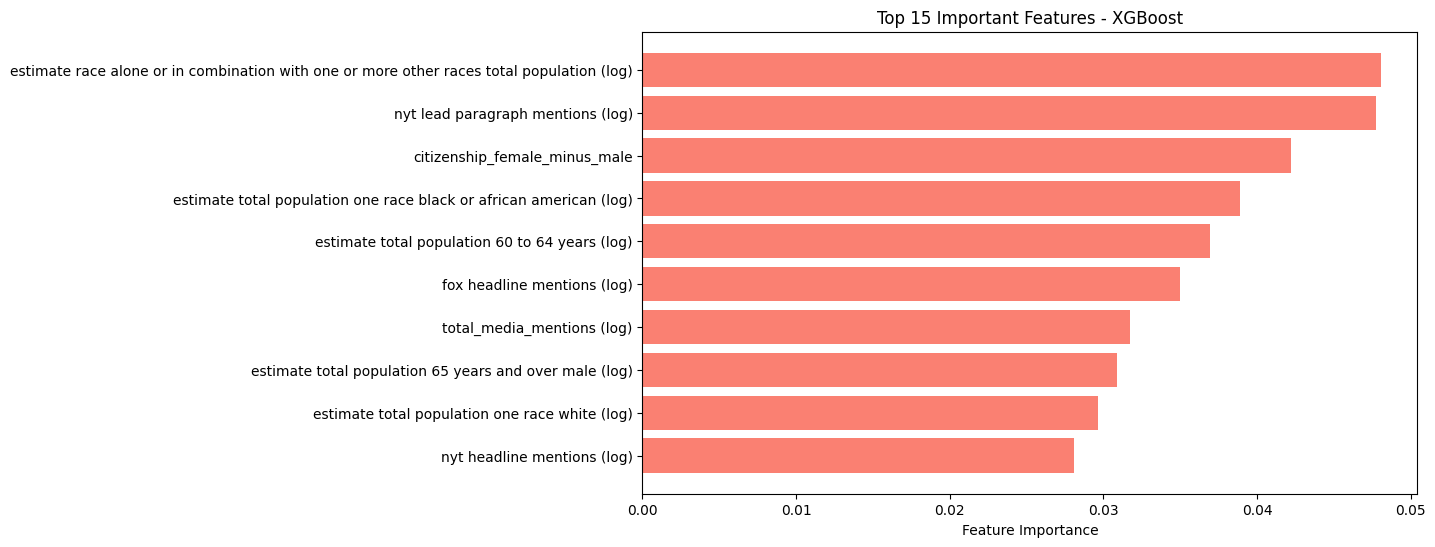

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import plot_importance

xgb_importances = xgb_final.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_importances
})

xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False).head(10)

print("\nTop 10 Important Features for XGBoost:")
for idx, row in xgb_importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['Feature'], xgb_importance_df['Importance'], color='salmon')
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - XGBoost')
plt.gca().invert_yaxis()
plt.show()
